In [75]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from flax import struct
from flax.training.train_state import TrainState
from flax.core import FrozenDict
from typing import Any, Dict, Tuple

import jax, jax.numpy as jnp
from jax.random import PRNGKey
from flax import linen as nn
from typing import Tuple


from typing import Optional, Tuple, Dict, Any, Sequence

from optax import linear_schedule

data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [108]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [109]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

In [110]:
empirical_freq_amp = jnp.zeros(next(iter(dict_amp.values())).shape[1])
num_total = 0

for arr in dict_amp.values():
    empirical_freq_amp += jnp.sum(arr, axis=0)
    num_total += arr.shape[0]

empirical_freq_amp = empirical_freq_amp / num_total

In [111]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1          # bound to class instance to make it compilable
    T: float = 1.0      # bound to class instance to make it compilable

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # cut off gradients after Gibbs sampling

        loss = jnp.mean(self._free_energy(data)) - jnp.mean(self._free_energy(gibbs_chain))
        return loss, {"gibbs_chain": gibbs_chain, "key": key}

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [131]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        gibbs_chain: jnp.ndarray,
        key: PRNGKey,
        p_reset: float) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")
    (basis_key, batch), = batch_dict.items()
    if set(basis_key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {basis_key}")

    key, reset_key = jax.random.split(key)

    def maybe_reset(chain, data_batch, key, p_reset):
        reset_mask = jax.random.bernoulli(key, p=p_reset, shape=chain.shape)
        return jnp.where(reset_mask, data_batch, chain)

    reset_chain = maybe_reset(gibbs_chain, batch, reset_key, p_reset)

    aux_vars = {"gibbs_chain": reset_chain, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"]


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey,
        p_min: float = 0.02,
        p_max: float = 0.30,
        reset_gain: float = 0.5,
        ema_alpha: float = 0.9) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}

    def estimate_entropy(chain: jnp.ndarray) -> float:
        indices = jnp.argmax(chain, axis=-1)
        counts = jnp.bincount(indices, length=chain.shape[-1])
        probs = counts / jnp.sum(counts)
        entropy = -jnp.sum(jnp.where(probs > 0, probs * jnp.log(probs), 0.0))
        return entropy

    H_target = jnp.log(gibbs_chain.shape[-1])
    H_ema = H_target  # start from max entropy to avoid premature resets

    for epoch in range(num_epochs):
        tot_loss = 0.0
        tot_entropy = 0.0
        tot_mode_count = 0.0
        batches = 0

        for batch_dict in loader:
            H_chain = estimate_entropy(gibbs_chain)
            H_ema = float(ema_alpha * H_ema + (1 - ema_alpha) * H_chain)
            p_reset = jnp.clip(reset_gain * (H_target - H_ema), a_min=p_min, a_max=p_max)

            state, loss, gibbs_chain, key = train_step_amp(
                state, batch_dict, gibbs_chain, key, float(p_reset)
            )

            tot_entropy += float(H_chain)
            tot_loss += float(loss)
            tot_mode_count += float(jnp.exp(H_chain))
            batches += 1

        avg_loss = tot_loss / batches
        avg_entropy = tot_entropy / batches
        avg_mode_count = tot_mode_count / batches

        lr = float(lr_schedule(state.opt_state[0].count))
        metrics[epoch] = {
            "loss_amp": avg_loss,
            "H_chain": avg_entropy,
            "mode_count": avg_mode_count,
            "lr": lr,
        }

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f} │ H_chain: {avg_entropy:.2f} │ ~Modes: {avg_mode_count:.1f} │ LR: {lr:.5f}")

    return state, metrics

In [161]:
# ---- hyperparameters ----
batch_size    = 64                                                    #  DONE
visible_units = 10   #                                                   DONE
hidden_units  = 16 # totally sufficient to capture all modes            DONE
k_steps       = 300 # more k-steps mean less variance in the loss
lr            = 1e-2
num_epochs    = 1000
chains        = batch_size


key_seed = PRNGKey(42)
key, key_params, key_chains, key_dummy = jax.random.split(key_seed, 4)

model_amp = RBM(visible_units, hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, visible_units), dtype=jnp.float32), "key": key_dummy}
variables_amp = model_amp.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=batch_size)

def sigmoid_schedule(init_lr, final_lr, decay_steps, a=0.01, center_step=None):
    if center_step is None:
        center_step = decay_steps / 2
    schedule = lambda step: final_lr + (init_lr - final_lr) / (1 + jnp.exp(a * (jnp.minimum(step, decay_steps) - center_step)))
    return schedule

schedule_steps = num_epochs * len(loader_amp)
lr_schedule = sigmoid_schedule(
    init_lr=1e-2,
    final_lr=1e-2 * 0.2,
    decay_steps=schedule_steps,
    a=0.003,
    center_step=schedule_steps * 0.2
)

# Use it in the optimizer
optimizer_amp = optax.adam(learning_rate=lr_schedule)

state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)
gibbs_chain = jax.random.bernoulli(key_chains, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

%time state_amp, metrics_amp = train_amp_rbm(state_amp, loader_amp, gibbs_chain, num_epochs, key=key, p_min=0.00, p_max=1, reset_gain=0.5)

Epoch 1/200 │ Loss: -0.3387 │ H_chain: 1.75 │ ~Modes: 5.8 │ LR: 0.01000
Epoch 2/200 │ Loss: -0.0632 │ H_chain: 1.80 │ ~Modes: 6.1 │ LR: 0.01000
Epoch 3/200 │ Loss: -0.0508 │ H_chain: 1.81 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 4/200 │ Loss: -0.0382 │ H_chain: 1.79 │ ~Modes: 6.0 │ LR: 0.01000
Epoch 5/200 │ Loss: -0.0160 │ H_chain: 1.82 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 6/200 │ Loss: -0.0269 │ H_chain: 1.80 │ ~Modes: 6.1 │ LR: 0.01000
Epoch 7/200 │ Loss: -0.0027 │ H_chain: 1.81 │ ~Modes: 6.1 │ LR: 0.01000
Epoch 8/200 │ Loss: 0.0092 │ H_chain: 1.81 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 9/200 │ Loss: -0.0026 │ H_chain: 1.81 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 10/200 │ Loss: 0.0309 │ H_chain: 1.81 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 11/200 │ Loss: 0.0063 │ H_chain: 1.81 │ ~Modes: 6.2 │ LR: 0.01000
Epoch 12/200 │ Loss: 0.0255 │ H_chain: 1.81 │ ~Modes: 6.1 │ LR: 0.01000
Epoch 13/200 │ Loss: 0.0167 │ H_chain: 1.80 │ ~Modes: 6.1 │ LR: 0.01000
Epoch 14/200 │ Loss: 0.0284 │ H_chain: 1.80 │ ~Modes: 6.1 │ LR: 0

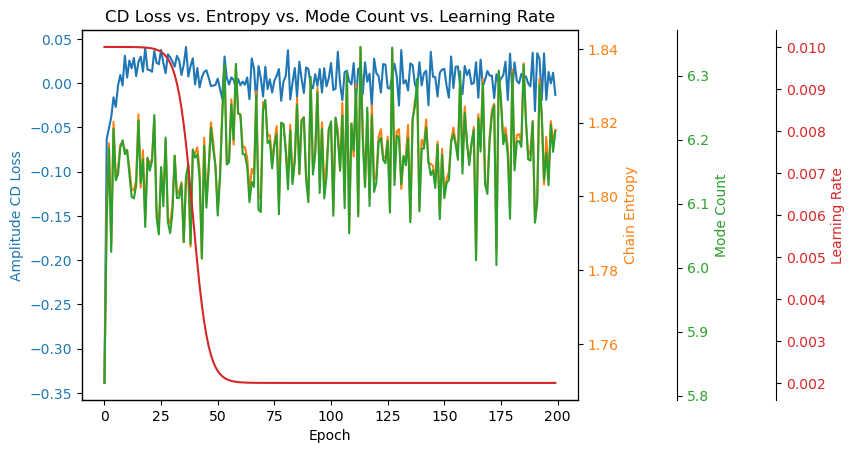

In [163]:
import matplotlib.pyplot as plt

epochs = list(metrics_amp.keys())
loss_vals = [metrics_amp[e]['loss_amp'] for e in epochs]
entropy_vals = [metrics_amp[e]['H_chain'] for e in epochs]
mode_vals = [metrics_amp[e]['mode_count'] for e in epochs]
lr_vals = [metrics_amp[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots()

# Left y-axis: CD loss
ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Amplitude CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis: Entropy
ax2 = ax1.twinx()
ax2.plot(epochs, entropy_vals, label="Chain Entropy", color="tab:orange")
ax2.set_ylabel("Chain Entropy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Third axis: Mode count (offset further right)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(epochs, mode_vals, label="Estimated Mode Count", color="tab:green")
ax3.set_ylabel("Mode Count", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

# Fourth axis: Learning rate (even further right)
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax4.set_ylabel("Learning Rate", color="tab:red")
ax4.tick_params(axis="y", labelcolor="tab:red")

plt.title("CD Loss vs. Entropy vs. Mode Count vs. Learning Rate")
plt.show()

In [156]:
def get_cosine_schedule(T_high, T_low, n_steps):
    steps = jnp.arange(n_steps, dtype=jnp.float32)
    cos = 0.5 * (1 + jnp.cos(jnp.pi * steps / (n_steps - 1)))
    return T_low + (T_high - T_low) * cos

def get_exponential_schedule(T_high, T_low, n_steps):
    steps = jnp.arange(n_steps, dtype=jnp.float32)
    exp = jnp.exp(-steps / (n_steps / 10))  # decay factor
    return T_low + (T_high - T_low) * exp

cosine_schedule = get_cosine_schedule(2.0, 0.1, 500)
exponential_schedule = get_exponential_schedule(2.0, 0.01, 1500)
constant_schedule = jnp.ones(500) * 1.2


key_sample = PRNGKey(12345)

samples_amp = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=exponential_schedule,
    key=key_sample,
    method=RBM.generate
)

sampled_freq_amp = samples_amp.mean(0)
sampled_freq_amp

Array([0.0837    , 0.1024    , 0.0817    , 0.0744    , 0.1012    ,
       0.0698    , 0.066     , 0.0749    , 0.22049999, 0.12539999],      dtype=float32)

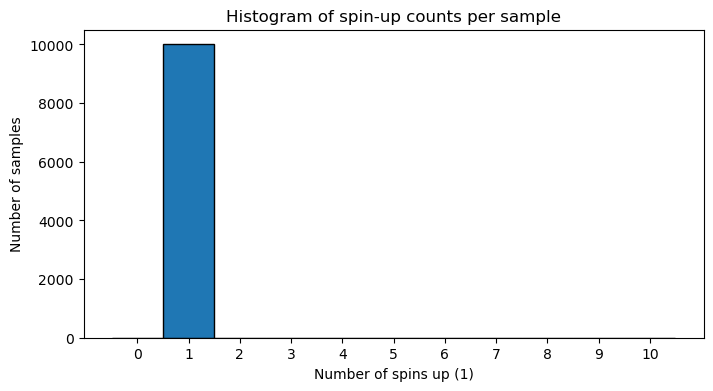

In [157]:
spin_counts = samples_amp.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

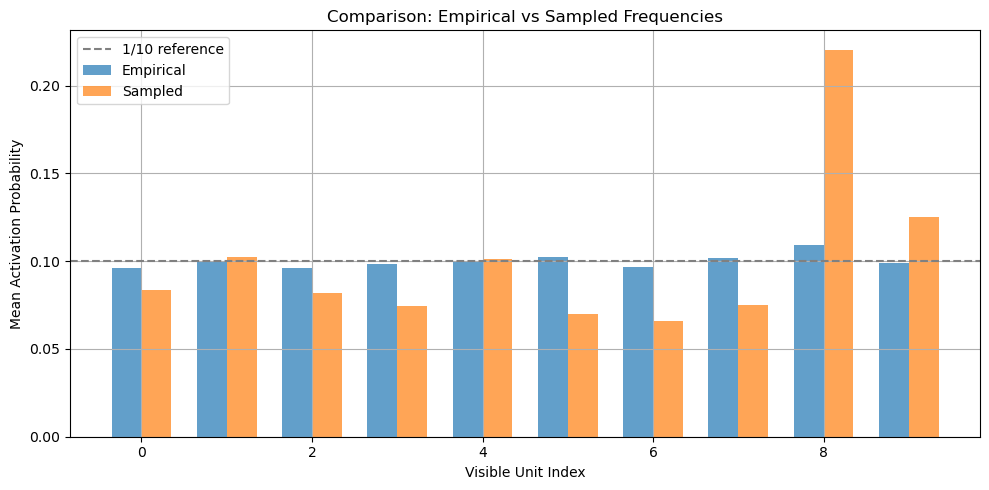

In [158]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq_amp, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, sampled_freq_amp, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()